In [11]:
import torch
from torchvision.datasets import MNIST
from torchvision import transforms
from torch.utils.data.dataset import random_split
from torch.utils.data import DataLoader

torch.manual_seed(2)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

batch_size = 128

train_dataset = MNIST(
  root="../../data", 
  download=True, 
  transform=transforms.ToTensor(),
  train=True
)
test_dataset = MNIST(
  root="../../data", 
  transform=transforms.ToTensor(),
  train=False
)

train_dataset, val_dataset = random_split(train_dataset, [55000, 5000])

train_loader = DataLoader(
  dataset=train_dataset,
  batch_size=batch_size,
  shuffle=True,
  num_workers=11,
)

val_loader = DataLoader(
  dataset=val_dataset,
  batch_size=batch_size,
  num_workers=11,
)

test_loader = DataLoader(
  dataset=test_dataset,
  batch_size=batch_size,
  num_workers=0,
)

example_img = test_dataset[0][0]
print(example_img.shape)


torch.Size([1, 28, 28])


In [12]:
import torch.nn as nn
import torch.nn.functional as F
from collections import OrderedDict
import torchmetrics
import lightning as L
from dataclasses import dataclass

class DownSample(L.LightningModule):
  def __init__(self, in_channels: int, out_channels: int):
    super().__init__()
    self.seq = nn.Sequential(OrderedDict([
      ('conv', nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1)),
      ('relu', nn.ReLU()),
      ('maxpool', nn.MaxPool2d(2)),
    ]))


  def forward(self, x):
    return self.seq(x)


class UpSample(L.LightningModule):
  def __init__(self, in_channels: int, out_channels: int, act_fn: nn):
    super().__init__()
    self.seq = nn.Sequential(OrderedDict([
      ('conv', nn.ConvTranspose2d(
        in_channels,
        out_channels,
        kernel_size=2,
        stride=2
      )),
      ('upsample-act-fn', act_fn),
    ]))

  def forward(self, x):
    return self.seq(x)

@dataclass
class StepData:
  loss: torch.tensor
  bce: float
  kld: float
  original_images: torch.Tensor
  reconstructions: torch.Tensor

class MnistVAE(L.LightningModule):
  def __init__(self):
    super().__init__()
    self.encode = nn.Sequential(OrderedDict([
      ('down1', DownSample(1, 32)),
      ('down2', DownSample(32, 64)),
      ('flatten', nn.Flatten()),
      ('mean_and_logvar', nn.Linear(3136, 40)),
    ]))

    self.decode = nn.Sequential(OrderedDict([
      ('lin2', nn.Linear(20, 3136)),
      ('unflatten', nn.Unflatten(1, (64, 7, 7))),
      ('up1', UpSample(64, 32, nn.ReLU())),
      ('up2', UpSample(32, 1, nn.Sigmoid())),
    ]))

  def forward(self, x):
    encoded_vec = self.encode(x)
    
    mean, logvar = encoded_vec.chunk(2, dim=1)

    # reparameterization trick
    std = torch.exp(0.5 * logvar)
    eps = torch.randn_like(std)
    random_sample = mean + eps * std

    return self.decode(random_sample), mean, logvar

  def _shared_step(self, batch):
    original_images, _unused_labels = batch
    reconstructions, mean, logvar = self(original_images)

    bce = F.binary_cross_entropy(reconstructions, original_images, reduction='sum')
    
    # Manually calculating KLD
    # kld = -0.5 * torch.sum(1 + logvar - mean.pow(2) - logvar.exp())

    # Using kl_div from PyTorch
    kld = F.kl_div(
       F.log_softmax(logvar, dim=1),
       F.softmax(mean, dim=1),
       reduction='sum'
    )
    
    return StepData(
      loss=bce + kld,
      bce=bce.item(),
      kld=kld.item(),
      original_images=original_images,
      reconstructions=reconstructions
    )

  def training_step(self, batch, batch_idx: int):
      step_data = self._shared_step(batch)

      self.log('train_loss', step_data.loss, prog_bar=True)
      self.log('train_bce', step_data.bce)
      self.log('train_kld', step_data.kld)

      return step_data.loss # this is passed to the optimizer for training

  def validation_step(self, batch, batch_idx: int):
      step_data = self._shared_step(batch)

      self.log('val_loss', step_data.loss, prog_bar=True)

  def test_step(self, batch, batch_idx: int):
      step_data = self._shared_step(batch)

  def configure_optimizers(self):
      optimizer = torch.optim.AdamW(self.parameters())
      return optimizer


In [13]:
import lightning as L
from torchinfo import summary

model = MnistVAE().to(device)
summary(model, input_size=(batch_size, 1, 28, 28), depth=2)

trainer = L.Trainer(
  max_epochs=3,
  accelerator='gpu',
  devices='auto' # Use all available GPUs if applicable
)

trainer.fit(
  model,
  train_dataloaders=train_loader,
  val_dataloaders=val_loader
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores


HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name   | Type       | Params | Mode 
----------------------------------------------
0 | encode | Sequential | 144 K  | train
1 | decode | Sequential | 74.2 K | train
----------------------------------------------
218 K     Trainable params
0         Non-trainable params
218 K     Total params
0.874     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=3` reached.


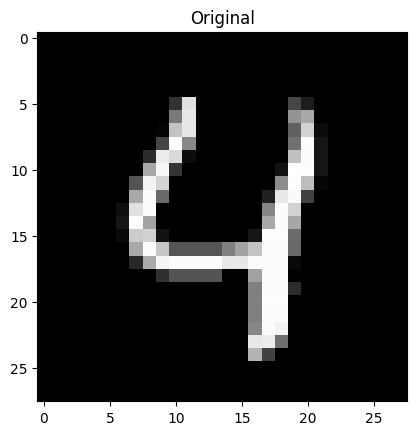

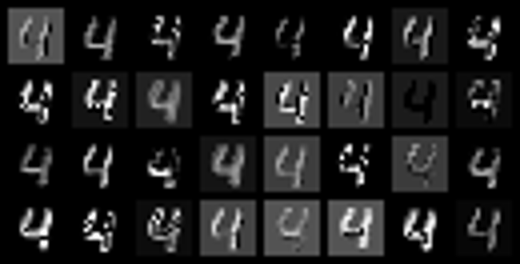

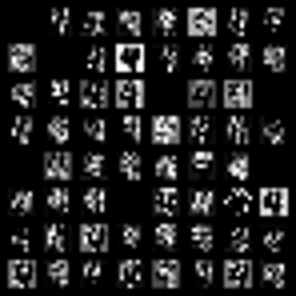

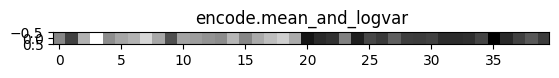

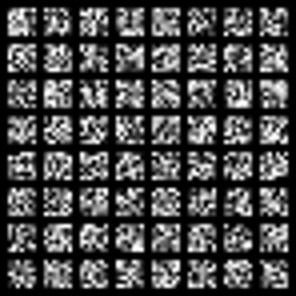

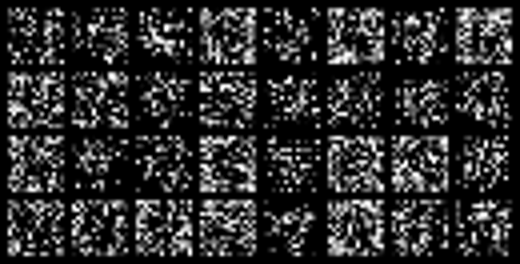

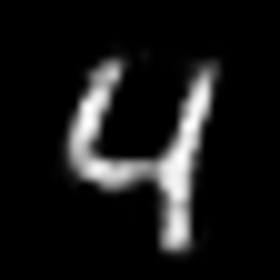

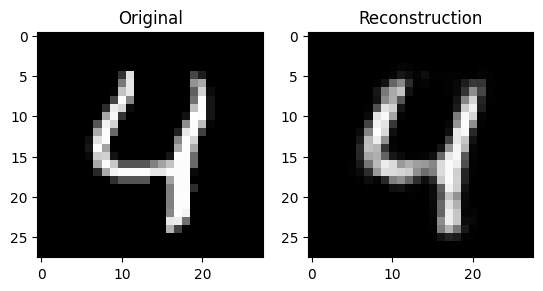

In [20]:
import torchvision
import matplotlib.pyplot as plt

if 'hooks' in locals():
  for hook in locals()['hooks']:
    hook.remove()

hooks: list[torch.utils.hooks.RemovableHandle] = []

layers = ['encode.down1', 'encode.down2', 'decode.unflatten', 'decode.up1', 'decode.up2']

img_h = 300

for layer in layers:
  def inspect(module, input, output: torch.Tensor):
      output = output.transpose(0, 1)
      grid = torchvision.utils.make_grid(output)
      img = torchvision.transforms.ToPILImage()(grid)
      resize = int(img_h / img.height)
      img.resize((resize * img.width, resize * img.height)).show()
  hooks.append(model.get_submodule(layer).register_forward_hook(inspect))

@model.get_submodule('encode.mean_and_logvar').register_forward_hook
def inspect_bottleneck(module, input, output: torch.Tensor):
  plt.title('encode.mean_and_logvar')
  plt.imshow(output.detach().numpy(), cmap='gray')
  plt.show()
hooks.append(inspect_bottleneck)

model.eval()

example_img = test_dataset[4][0]

plt.title('Original')
plt.imshow(example_img.view(28, 28).detach().numpy(), cmap='gray')
plt.show()

# do the forward pass
reconstruction, mean, logvar = model(example_img.view(1, 1, 28, 28))

from matplotlib import pyplot as plt

fig, (ax1, ax2) = plt.subplots(1, 2)
plt.sca(ax1)
plt.title('Original')
plt.imshow(example_img.view(28, 28), cmap='gray')

plt.sca(ax2)
plt.title('Reconstruction')
plt.imshow(reconstruction.view(28, 28).detach().numpy(), cmap='gray')

for hook in hooks:
  hook.remove()


In [15]:
from ipywidgets import interact, widgets

def get_example(num: int):
  return next((img for (img, label) in test_dataset if label == num), None)

@interact(
    num_a=widgets.IntSlider(min=0, max=9, step=1, value=2, continuous_update=False),
    blend_factor=widgets.FloatSlider(min=0, max=1, step=0.1, value=0, continuous_update=False),
    num_b=widgets.IntSlider(min=0, max=9, step=1, value=4, continuous_update=False),
)
def mix_nums(num_a: int, blend_factor: float, num_b: int):
  example_img_1 = get_example(num_a)
  example_img_2 = get_example(num_b)

  latent_1 = model.encode(example_img_1.view(1, 1, *example_img_1.shape[-2:]))
  latent_2 = model.encode(example_img_2.view(1, 1, *example_img_2.shape[-2:]))

  blended_latent = (latent_1 * (1-blend_factor)) + (latent_2 * blend_factor)

  recon_1 = model.decode(latent_1.chunk(2, dim=1)[0])
  recon_2 = model.decode(latent_2.chunk(2, dim=1)[0])
  between = model.decode(blended_latent[:,:20])

  fig, (ax1, ax2, ax3) = plt.subplots(1, 3)

  plt.sca(ax1)
  plt.title('Reconstructed 1')
  plt.imshow(recon_1.view(28, 28).detach().numpy(), cmap='gray')

  plt.sca(ax2)
  plt.title('Between')
  plt.imshow(between.view(28, 28).detach().numpy(), cmap='gray')

  plt.sca(ax3)
  plt.title('Reconstructed 2')
  plt.imshow(recon_2.view(28, 28).detach().numpy(), cmap='gray')


interactive(children=(IntSlider(value=2, continuous_update=False, description='num_a', max=9), FloatSlider(val…